## Downloading Twitter Data from Twitter Developers API  

This Jupyter Notebook aims to give the reader a brief overview of the Twitter Developers API and how to retrieve tweets and trending topics information from it. Some data visualization will be thrown in as well. The Notebook is organized as follows:  
 
1. How to get a **Twitter Developers Account**;
2. Authentication and the **tweepy** library;
3. Retrieving tweets from a specific **user**;
4. Obtaining tweets given a **keyword** or **hashtag**;
5. Retrieving trending topics in a set **region or area**;
6. Getting past tweet limit using **Cursor**.

In [31]:
import tweepy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import SnowballStemmer

sns.set_theme(style='whitegrid')

Importing libraries

## 1. How to get a Twitter Developers Account

First, we need to get a Developers Account from Twitter. To do so, click on the following [link](https://developer.twitter.com) and apply for free. You will only need to provide some information about the research you plan on pursuing (learning how to use the API is a valid answer).  
Once you have an approved Developers Account: 
1. Create a project and connect an App through the Developer Portal;
2. Go to the Developer Portal dashboard;
3. Sign in with your developer account;
4. Create a new project, give it a name, a use-case based on the goal you want to achieve, and a description.

If everything goes as planned, you will be able to see the page containing your **keys** and **tokens**, that you need to access the API.

## 2. Authentication and the tweepy library  

The [tweepy](https://docs.tweepy.org/en/stable/install.html) library allows you to interact with the Twitter API directly from Python. It has a few authentication methods, and it is reccomended to check the library's documentation to devide which one is best for your use case. I will be using the **OAuth Method**.

OAuth is a method of authentification where the application makes API requests without the user context. Use this if you just need read-only access to publicly available information.
First, you register the client application and acquire a **consumer key** and **secret**. Then, create an *AppAuthHandler* instance, passing in consumer key and secret.


In [32]:
# Authentication 

apiKey = 'wMzFjW05ShZpRz6L9GNzeU9Xk'
apiSecret = 'pbs2GYtMhzODB6aC0GRP1KqzKIYFbaI3JkZ00Si5CEYQmbFGlQ'
accessToken = '1013061841524871168-otkhIu0sDFcdWVvqGcJ5iwOUeMbY4X'
accessTokenSecret = 'aJFCoPlh9ZRnKYWw3TaCwaLzInhVHtPjcofCTc0L3kzr0'

auth = tweepy.OAuthHandler(apiKey, apiSecret)
auth.set_access_token(accessToken, accessTokenSecret)
api = tweepy.API(auth)

## 3. Retrieving tweets from a specific user
The standard for getting tweets from a user is *tweepy.API.user_timeline()* which, if not else stated, gets you the last tweets from one user; the parameters of this call allows you to:
* select **number of tweets** you want to obtain, up to 200 (*count=*);
* include/exclude **replies** (*exclude_replies=*);
* include/exclude **retweets** (*include_rts=*).  

Remember that Twitter API by default only retrieves the *truncated* text of tweets: if what interests you is the **full text** you have to specify this by using (*tweet_mode='extended'*).

Here, I am requesting tweets from Joe Biden's presidential account (POTUS) for demonstration purposes.

In [33]:
# reading tweets from a user
user = 'POTUS'
lim = 200   # max = 200 when searching from a user

tweets_user = api.user_timeline(screen_name=user, count=lim, tweet_mode='extended') # by default tweets are truncated
for tweet in tweets_user[0:2]:
    print(tweet.full_text)

I made clear that Russia would pay a severe and immediate price for its atrocities in Bucha. Today, along with our Allies and partners, we’re announcing a new round of devastating sanctions. https://t.co/LVqTDIOSvz
Today, my Administration is extending the pause on federal student loan repayments through August 31st, 2022. https://t.co/xwicA1hCW3


Now, printing the full text is probably not what you want. We now create a dataframe from the retrieved information, displaying informations such as the date the tweet was posted, the number of likes (which in Twitter are called "favourites"), the number of retweets and, whether the post was a retweet or not and whether it was a response to someone else's tweet.

The request result is in json format, and many more informations can be extracted from it: for a full review, see the [documentation](https://developer.twitter.com/en/docs/twitter-api/v1/tweets/timelines/api-reference/get-statuses-user_timeline).

In [34]:
# create dataframe

columns = ['User', 'Tweet', 'Date_Posted', 'Favourite_Count', 'Retweet_Count', 'Reply_To']

data = []

for tweet in tweets_user:
    data.append([tweet.user.screen_name, tweet.full_text, tweet.created_at, tweet.favorite_count, tweet.retweet_count, tweet.in_reply_to_screen_name])

user_tweets_df = pd.DataFrame(data, columns=columns)

user_tweets_df.head()

,User,Tweet,Date_Posted,Favourite_Count,Retweet_Count,Reply_To
0,POTUS,I made clear that Russia would pay a severe an...,2022-04-06 14:40:24+00:00,1525,373,None
1,POTUS,"Today, my Administration is extending the paus...",2022-04-06 14:02:25+00:00,6429,1150,None
2,POTUS,"Twelve years ago, I had the honor of being gif...",2022-04-06 00:08:36+00:00,21408,2561,None
3,POTUS,"Once today’s proposed rule is finalized, start...",2022-04-05 23:20:27+00:00,4224,624,POTUS
4,POTUS,"Here's the problem: Under the current rules, a...",2022-04-05 23:20:27+00:00,4866,665,POTUS


Retrieving tweets from a user can seem like a trivial exercise at first, but it might be a useful method to understand said person.  
For example, we could visualize which are the **most frequent words** our user has used, or we could employ some **topic modelling** algorithm or **n-grams** wordcounts to understand what the user has recently communicated about.

In [35]:
nlp = spacy.load('en_core_web_sm')

# Set the stop_word tag on the lexeme
stopwords = nlp.Defaults.stop_words

# The Snowball Stemmer requires that you pass a language parameter
s_stemmer = SnowballStemmer(language='english')

def clean_text(text):

    text_lc = "".join([word.lower() for word in text if word not in string.punctuation]) # remove puntuation
    text_rc = re.sub('[0-9]+', '', text_lc)
    tokens = re.split('\W+', text_rc)    # tokenization
    text = [s_stemmer.stem(word) for word in tokens if word not in stopwords]  # remove stopwords and stemming
    
    return text

In [36]:
def plot_most_freq_words(data):

    ### plots the 10 most frequent words in a df of tweets
    ### makes use of the clean_text() function before actually counting vectors
    countVectorizer = CountVectorizer(analyzer=clean_text) 
    countVector = countVectorizer.fit_transform(data['Tweet'])

    count_vect_df = pd.DataFrame(countVector.toarray(), columns=countVectorizer.get_feature_names_out())
    count_vect_df.head()

    count = pd.DataFrame(count_vect_df.sum())
    countdf = count.sort_values(0,ascending=False).head(20)
    countdf.rename(columns={0:'WordCount'}, inplace=True)
    countdf = countdf[2:12]

    ax = sns.barplot(y='WordCount',x=countdf.index, data=countdf, palette="Blues_d").set(title=(str('Most frequent words by '+user)))

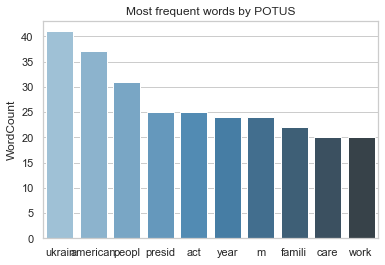

In [37]:
plot_most_freq_words(user_tweets_df)

## 4. Obtaining tweets given a keyword or hashtag  

The call *tweepy.API.search_tweets()* returns a collection of relevant tweets matching a specific **query** (q).  

Please note that Twitter's search service and, by extension, the Search API is not meant to be an exhaustive source of Tweets. Not all Tweets will be indexed or made available via the search interface. To learn how to use Twitter Search effectively, see the Standard search operators page for a list of available filter operators. Also, see the page https://developer.twitter.com/en/docs/twitter-api/v1/tweets/timelines/guides/working-with-timelines to learn best practices for navigating results.  

The *maximum limit* for the *search_tweets* call is 100 and the parameters in this call allows you to:
* returning tweets by users located within a given radius of the given **latitude/longitude** (*geocode=(latitude, longitude, radius)*);
* restricting tweets to the given **language**, given by ISO 639-1 code (*lang=*);
* the **number** of tweets to return, up to 100 (*count=*);
* returning tweets created **before a given date** (*until=YYYY-MM-DD*); keep in mind that search limit is 7 days;
* specify the **type of results** obtained in the response (*result_type=*)
    * *mixed*: include both popular and real time results;
    * *recent*: return only most recent results;
    * *popular*: return only the most popular results.

Once again, many more parameters for your research can be found in the [documentation](https://developer.twitter.com/en/docs/twitter-api/v1/tweets/search/api-reference/get-search-tweets)


In [38]:
# here the maximum limit for searching is 100 at a time..

keyword = 'biden' # enter keyword / hashtag(#) / user (@) to search  
noOfTweet = 100 # enter number of tweets wanted

tweets_kw = api.search_tweets(q=keyword, count=noOfTweet, lang='en',result_type='mixed',tweet_mode='extended')

columns = ['User', 'Tweet', 'Date_Posted', 'Favourite_Count', 'Retweet_Count', 'Reply_To']

data = []

for tweet in tweets_kw:
    data.append([tweet.user.screen_name, tweet.full_text, tweet.created_at, tweet.favorite_count,tweet.retweet_count, tweet.in_reply_to_screen_name])

kw_tweets_df = pd.DataFrame(data, columns=columns)

kw_tweets_df.head()

,User,Tweet,Date_Posted,Favourite_Count,Retweet_Count,Reply_To
0,RNCResearch,Literally no one wants to talk to Joe Biden ht...,2022-04-05 18:27:20+00:00,37717,9473,None
1,CarlaHSands,Elon Musk has done more to advance freedom in ...,2022-04-05 12:44:52+00:00,114827,15810,None
2,greg_price11,Mitt Romney's last few weeks:\n\n- Confirmed K...,2022-04-05 00:36:39+00:00,19007,5671,None
3,HowardB19550618,RT @kylegriffin1: NBC News: The Biden admin pl...,2022-04-06 14:49:19+00:00,0,253,None
4,dgilliam147,RT @OccupyDemocrats: BREAKING: Trumper Lindsey...,2022-04-06 14:49:19+00:00,0,8163,None


## 5. Retrieving trending topics in a set region or area;

To get trending topics **in a specific location** the *tweepy.API.get_place_trends*, which returns the **50 most recent trending topics**, is available. The call *api.available_trends()* shows **all** the ids for which trends are **available** on Twitter, while the call *api.closest_trends(lat=, long=)* shows which is the WOEID with available trends **nearest** to the indicated position (latitude and longitude). 

Note that for the purpose of setting the location you need to use the *id* parameter, which corresponds to the "**Where On Earth Identifier**" ([WOEID](https://woeplanet.org/id/23424853/)).  

The *created_at* field will show when the oldest trend started trending. The *as_of* field contains the timestamp of when the list of trends was created. The **tweet_volume** for the last 24 hours is also returned for each trend if available. It is possible to use *exclude* to leave out hashtags from the result.

In [39]:
# WOEID of Italy
loc = 'Italy'
woeid = 23424853
 
# fetching the trends
trends = api.get_place_trends(id = woeid)
 
# printing the information
print('The top trends for', loc, 'are:')

for value in trends:
    for trend in value['trends']:
        print(trend['name'])

The top trends for Italy are:
#uominiedonne
Riccardo
#MultiverseOfMadness
#CarbonaraDay
#DoctorStrange
Pinuccia
#cinesantori
Tina
Donato
Borsellino
Picierno
Lukaku
Veronica
Gloria
Armando
Pirlo
Chelsea
Lakers
Toni Capuozzo
#MoonKnight
#oche
#ScarletWitch
#6aprile
#sardine
#ParmaComo
#FamilyAct
#terremoto
#summertime
#Paragone
#LouisTomlinsonWorldTour2022
#Osimhen
#Zaniolo
#braveandbeautiful
#laquila
#ijf22
#CriminiDiGuerra
#lariachetira


Note that trends is a **dictionary inside a list of length 1**. Treat it like trends[0]['trends'] and so on to get specific values

In [40]:
trends[0]['trends'][0]['name']

'#uominiedonne'

Now, let's sort trends and visualize which are the most popular in Italy at the moment, and the tweet volume for each of them

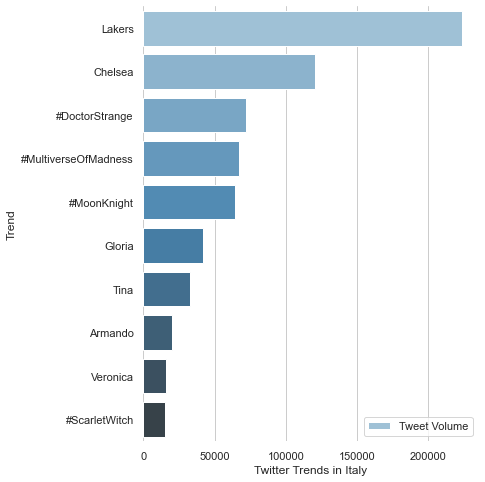

In [41]:
columns = ['Trend', 'Tweet_Volume']

data = []

for t in trends:
    for trend in t['trends']:
        data.append([trend['name'], trend['tweet_volume']])

trends_df = pd.DataFrame(data, columns=columns)
trends_df.dropna(inplace=True)

trends_df = trends_df.sort_values('Tweet_Volume',ascending=False)

# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 8))

# Plot the tweet volume for each trend
sns.set_color_codes('pastel')
sns.barplot(x='Tweet_Volume', y='Trend', data=trends_df, palette="Blues_d", label='Tweet Volume')

# Add a legend and informative axis label
ax.legend(ncol=1, loc='lower right', frameon=True)
ax.set(ylabel='Trend', xlabel=(str('Twitter Trends in '+loc)))
sns.despine(left=True, bottom=True)


## 6. Getting past tweet limit using Cursor  

Remember that Twitter API allows to download only 100/200 tweets at a time: what if we wanted more?
If you want to search for, say, the last 1000 tweets from a user, you need a [Cursor](https://docs.tweepy.org/en/stable/api.html) to iterate through searching results. 
The tweet rate limit here is:
* 1500 every 15 minutes for user tweets;
* 3200 every 15 minutes for keywords/hashtag search.


In [42]:

user = 'POTUS'
lim = 1000

tweets = tweepy.Cursor(api.user_timeline, screen_name=user, tweet_mode='extended').items(lim)

columns = ['User', 'Tweet', 'Date_Posted', 'Favourite_Count', 'Retweet_Count', 'Reply_To']

data = []

for tweet in tweets:
    data.append([tweet.user.screen_name, tweet.full_text, tweet.created_at, tweet.favorite_count, tweet.retweet_count, tweet.in_reply_to_screen_name])

user_tweets_df = pd.DataFrame(data, columns=columns)

user_tweets_df

,User,Tweet,Date_Posted,Favourite_Count,Retweet_Count,Reply_To
0,POTUS,I made clear that Russia would pay a severe an...,2022-04-06 14:40:24+00:00,1529,374,None
1,POTUS,"Today, my Administration is extending the paus...",2022-04-06 14:02:25+00:00,6442,1153,None
2,POTUS,"Twelve years ago, I had the honor of being gif...",2022-04-06 00:08:36+00:00,21409,2561,None
3,POTUS,"Once today’s proposed rule is finalized, start...",2022-04-05 23:20:27+00:00,4224,624,POTUS
4,POTUS,"Here's the problem: Under the current rules, a...",2022-04-05 23:20:27+00:00,4868,665,POTUS
...,...,...,...,...,...,...
995,POTUS,I’m meeting with President Xi of the People’s ...,2021-11-16 02:16:23+00:00,27128,3219,None
996,POTUS,Access to high-speed internet is as essential ...,2021-11-16 00:05:06+00:00,13864,2222,None
997,POTUS,"Here in Washington, we’ve heard countless spee...",2021-11-15 23:25:20+00:00,16816,2936,None
998,POTUS,The Bipartisan Infrastructure Law is a blue-co...,2021-11-15 23:17:12+00:00,9873,1473,None
